In [1]:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
from scipy import signal
from IPython.display import display


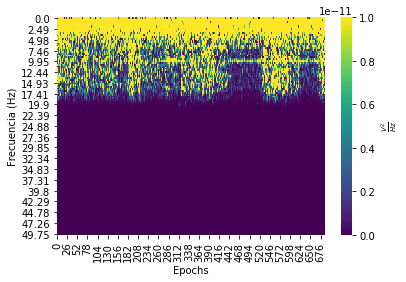

In [2]:
x = (sc.io.loadmat('datasetP/P02.mat'))['data']

epochs = len(x)
# epochs = 2
electrodes = 256
measures = 201

powersDF = None

for i in range(epochs):
    epoch = pd.DataFrame(x[i])
    fourier = sc.signal.welch(epoch.loc[[7, 43, 79, 130, 184]].mean(), nperseg=measures)
    if powersDF is None:
        powersDF = pd.DataFrame(index = np.round(np.multiply(fourier[0], 100), 2))
    powersDF[i] = pd.Series(fourier[1], index = powersDF.index)
sns.heatmap(powersDF, cmap = 'viridis', vmin = 0, vmax = 1e-11, cbar_kws = {'label': r'$\frac{V^{2}}{Hz}$'})
plt.xlabel('Epochs')
plt.ylabel('Frecuencia (Hz)')
plt.show()


In [11]:
deltaRange = [0.0 / 100.0, 4.0 / 100.0]
thetaRange = [4.0 / 100.0, 8.0 / 100.0]
alphaRange = [8.0 / 100.0, 13.0 / 100.0]
betaRange = [13.0 / 100.0, 30.0 / 100.0]
gammaRange = [30.0 / 100.0, 50.0 / 100.0]
classification = ['P'] * 10 + ['S'] * 10
names = map((lambda x: ('0'+ str(x))[-2:]), range(1,11))
# names = ['02']
datasets = ['datasetP/P', 'datasetS/S']
# datasets = ['datasetP/P']

subjectsDelta = []
subjectsTheta = []
subjectsAlpha = []
subjectsBeta = []
subjectsGamma = []
bandNames = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

df = pd.DataFrame(columns = bandNames)

for dataset in datasets:
    for name in names:
        x = (sc.io.loadmat(dataset + name + '.mat'))['data']
        epochs = len(x)
#         epochs = 2
        electrodes = 256
        measures = 201

        epochAcum = None
        for i in range(epochs):
            epoch = (pd.DataFrame(x[i])).sum()
            if epochAcum is None:
                epochAcum = epoch
            else:
                epochAcum = epochAcum.add(epoch)
#             fourier = sc.signal.welch(epoch, nperseg=measures)
#             plt.plot(np.round(np.multiply(fourier[0], 100), 2), fourier[1])
#         plt.show()
        
        epochAcum = epochAcum.divide(epochs * electrodes)
        fourier = sc.signal.welch(epochAcum, nperseg=measures)

        frecs = fourier[0]
        powers = fourier[1]
        theta = (i for i, v in enumerate(frecs) if v >= thetaRange[0] and v < thetaRange[1]).next()
        alpha = (i for i, v in enumerate(frecs) if v >= alphaRange[0] and v < alphaRange[1]).next()
        beta = (i for i, v in enumerate(frecs) if v >= betaRange[0] and v < betaRange[1]).next()
        gamma = (i for i, v in enumerate(frecs) if v >= gammaRange[0] and v < gammaRange[1]).next()
        subjectsDelta.append(powers[:theta].mean())
        subjectsTheta.append(powers[theta:alpha].mean())
        subjectsAlpha.append(powers[alpha:beta].mean())
        subjectsBeta.append(powers[beta:gamma].mean())
        subjectsGamma.append(powers[gamma:].mean())
        index = len(subjectsDelta)
        df = df.append((pd.Series({bandNames[0]: subjectsDelta[-1], bandNames[1]: subjectsTheta[-1], bandNames[2]: subjectsAlpha[-1], bandNames[3]: subjectsBeta[-1], bandNames[4]: subjectsGamma[-1]})).rename('Subject ' + names[(index - 1) % 10] + ' ' + classification[index - 1]))
#         plt.plot(np.round(np.multiply(fourier[0], 100), 2), fourier[1])
#         plt.show()
display(df)

,Delta,Theta,Alpha,Beta,Gamma
Subject 01 P,9.095474e-15,5.914937e-16,2.248727e-16,5.647098e-17,2.287231e-26
Subject 02 P,5.836480e-15,1.816941e-16,8.200576e-17,1.843154e-17,3.572753e-27
Subject 03 P,8.541264e-15,3.263710e-16,1.603465e-16,2.244956e-17,1.174758e-26
Subject 04 P,8.642325e-16,2.064799e-17,2.703804e-18,3.799370e-19,6.767615e-27
Subject 05 P,3.782237e-14,6.217611e-15,2.435598e-15,4.572183e-16,2.907462e-25
Subject 06 P,2.544677e-16,9.178082e-18,1.723626e-18,4.044180e-19,1.545403e-27
Subject 07 P,1.231416e-14,2.316077e-15,8.594945e-17,1.733532e-17,7.339451e-26
Subject 08 P,3.826212e-14,5.502114e-16,5.510924e-17,9.589336e-18,4.167759e-25
Subject 09 P,1.043020e-12,1.629944e-13,1.320894e-13,3.958321e-14,3.146001e-24
Subject 10 P,3.203127e-16,6.027165e-18,1.871741e-18,4.235000e-19,2.226020e-27


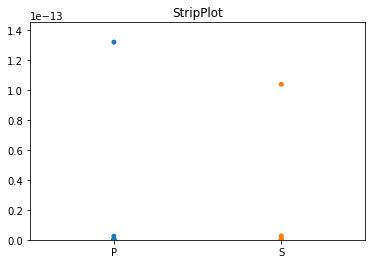

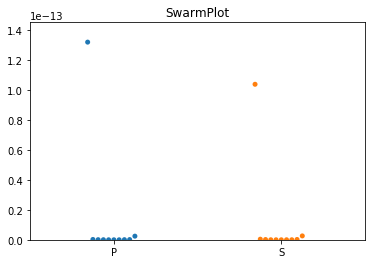

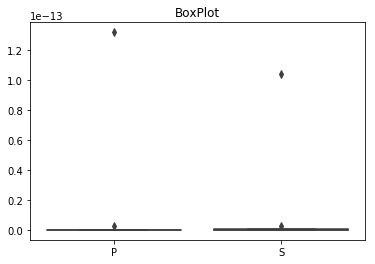

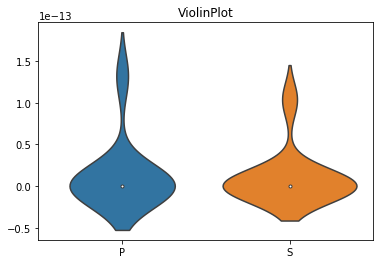

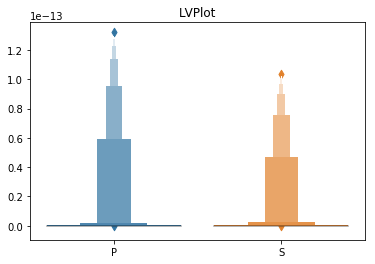

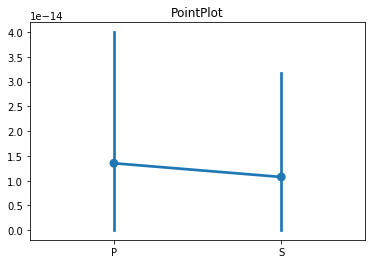

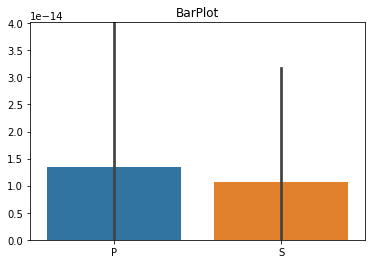

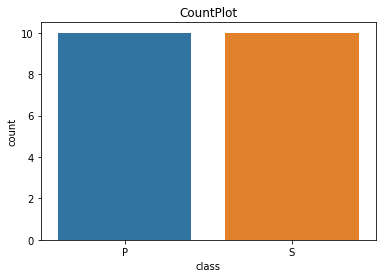

In [9]:
df = pd.DataFrame({'P': subjectsAlpha[:10], 'S': subjectsAlpha[10:]})
plotNames = ['StripPlot', 'SwarmPlot', 'BoxPlot', 'ViolinPlot', 'LVPlot', 'PointPlot', 'BarPlot', 'CountPlot']
plots = [sns.stripplot, sns.swarmplot, sns.boxplot, sns.violinplot, sns.lvplot, sns.pointplot, sns.barplot]

for i, plotClass in enumerate(plots):
    fig = plotClass(data = df)
    if (i < 2):
        fig.set_ylim([0, df['P'].max() * 1.1])
    plt.title(plotNames[i])
    plt.show()

df_new = pd.DataFrame({'class': ['P'] * 10 + ['S'] * 10, 'values': subjectsAlpha})
sns.countplot(x = 'class', data = df_new)
plt.title(plotNames[-1])
plt.show()


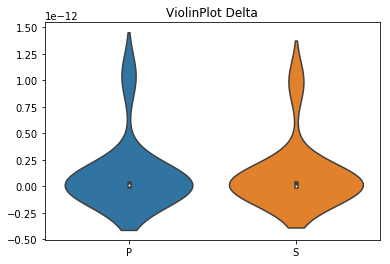

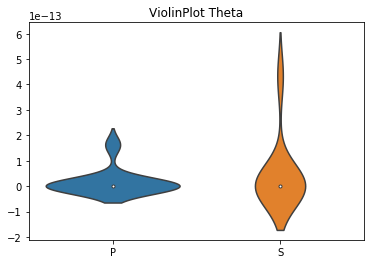

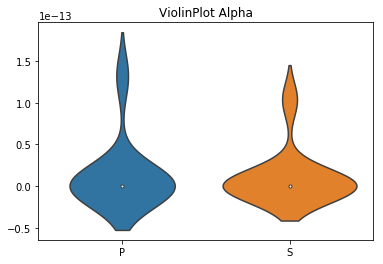

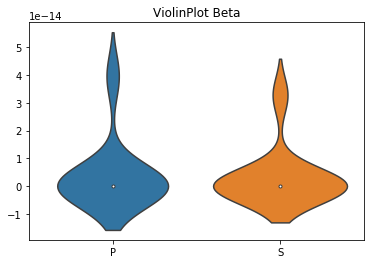

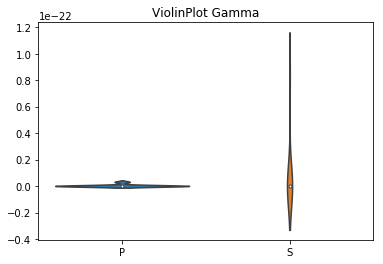

In [16]:
subjectsBands = [subjectsDelta, subjectsTheta, subjectsAlpha, subjectsBeta, subjectsGamma]
for i, subjectsBand in enumerate(subjectsBands):
    df = pd.DataFrame({'P': subjectsBand[:10], 'S': subjectsBand[10:]})
    sns.violinplot(data = df)
    plt.title('ViolinPlot ' + bandNames[i])
    plt.show()
    